<a href="https://colab.research.google.com/github/Dienert/reviews_analyzer/blob/main/notebooks/4%20-%20CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference:

https://github.com/dipanjanS/nlp_workshop_odsc_europe20/blob/master/notebooks/Module_03_NLP%20Applications%20-%20Machine%20and%20Deep%20Learning/12_NLP_Applications_Text_Classification_Deep_Learning_CNN_Models.ipynb

# Text Classification - Deep Learning CNN Models

In [2]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dav\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

## Load Movie Review Dataset

In [ ]:
# dataset = pd.read_csv(r'https://github.com/dipanjanS/nlp_workshop_dhs18/raw/master/Unit%2011%20-%20Sentiment%20Analysis%20-%20Unsupervised%20Learning/movie_reviews.csv.bz2', compression='bz2')
# dataset.info()

In [ ]:
# take a peek at the data
# dataset.head()

### Prepare Train Test Split

In [6]:
import pandas as pd

In [7]:
label_type = 'final_label'

In [10]:
train = pd.read_csv(f'../dataset/{label_type}/train.csv')
train

,x,y
0,Four Stars. thought provoking,1
1,Not What I Expected. Although a few of the sto...,0
2,Outliers - Gladwell - A Good Tour of the Outer...,1
3,Surprisingly good..... .. Interesting connecti...,1
4,Success. Good book to read for success,2
...,...,...
3420,Thoughts on Gladwell's Outliers: An exceptiona...,2
3421,Spellbinding. I haven't read other Gladwell bo...,2
3422,Very Thought Provoking. Excellent book. This b...,2
3423,Very Interesting and Well Done. This book help...,1


In [11]:
train_reviews = train.x.values
train_sentiments = train.y.map({0: 'negative', 1:'positive', 2:'positive'})

In [12]:
train_sentiments.value_counts()

positive    2751
negative     674
Name: y, dtype: int64

In [13]:
train_reviews = train_reviews[:700]
train_sentiments = train_sentiments[:700]
train_sentiments.value_counts()

positive    567
negative    133
Name: y, dtype: int64

In [14]:
train_sentiments = train_sentiments.values

In [17]:
test = pd.read_csv(f'../dataset/{label_type}/test.csv')
test

,x,y
0,A great read and worth every penny!. My first ...,2
1,"Senior English. Dear Mr. Gladwell,  am a seni...",1
2,Outliers - Gladwell - A Good Tour of the Outer...,1
3,Five Stars. I like Malcolm Gladwell books.,2
4,A Different Perspective on the Nature of Succe...,2
...,...,...
537,Worth the money. page quality is good but its ...,1
538,Absolute Genius. This is the first book I read...,2
539,Excellent book. Outliers is an intriguing book...,2
540,Another article turned into a book. This is ye...,0


In [18]:
test_reviews = test.x.values
test_sentiments = test.y.map({0: 'negative', 1:'positive', 2:'positive'})
test_sentiments.value_counts()

positive    435
negative    107
Name: y, dtype: int64

In [19]:
test_sentiments = test_sentiments.values

# Text Wrangling & Normalization

In [22]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [23]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

100%|██████████| 542/542 [00:00<00:00, 3097.11it/s]

CPU times: total: 391 ms
Wall time: 420 ms


## Preprocessing

To prepare text data for our deep learning model, we transform each review into a sequence.
Every word in the review is mapped to an integer index and thus the sentence turns into a sequence of numbers.

To perform this transformation, keras provides the ```Tokenizer```

In [24]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [25]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('brighter', 3844), ('<PAD>', 0), 1)

In [26]:
train_sequences = t.texts_to_sequences(norm_train_reviews)

In [27]:
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [28]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=3845
Number of Documents=700


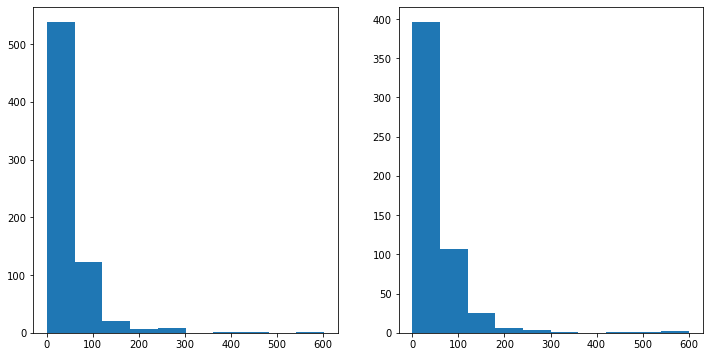

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

### Sequence Normalization

Not all reviews are of same length. To handle this difference in length of reviews, we define a maximum length.
For reviews which are smaller than this length, we pad them with zeros which longer ones are truncated

In [30]:
MAX_SEQUENCE_LENGTH = 1000

In [31]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((700, 1000), (542, 1000))

### Encoding Labels

The dataset contains labels of the form positive/negative. The following step encodes the labels using ```sklearn's``` ```LabelEncoder```

In [32]:
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [33]:
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [34]:
VOCAB_SIZE = len(t.word_index)

## Prepare the Model

Since textual data is a sequence of words, we utilize ```1D``` convolutions to scan through the sentences.
The model first transforms each word into lower dimensional embedding/vector space followed by 1d convolutions and then passing the data through dense layers before the final layer for classification

In [35]:
EMBED_SIZE = 300
EPOCHS=2
BATCH_SIZE=128

In [ ]:
# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

## Model Training

In [37]:
# Fit the model
model.fit(X_train, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=1)

Epoch 1/2
5/5 [==============================] - 5s 945ms/step - loss: 0.5607 - accuracy: 0.8048 - val_loss: 0.4415 - val_accuracy: 0.8571
Epoch 2/2


Error: Canceled future for execute_request message before replies were done

## Model Evaluation

In [ ]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

17/17 [==============================] - 1s 31ms/step - loss: 0.5057 - accuracy: 0.8026
Accuracy: 80.26%


In [ ]:
predictions = model.predict(X_test).ravel()
predictions[:10]

array([0.738365  , 0.69238406, 0.74033964, 0.7452268 , 0.74193907,
       0.7434341 , 0.7403727 , 0.74183327, 0.74020994, 0.73831695],
      dtype=float32)

In [ ]:
predictions = ['positive' if item >= .5 else 'negative' for item in predictions]
predictions[:10]

['positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive']

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       107
    positive       0.80      1.00      0.89       435

    accuracy                           0.80       542
   macro avg       0.40      0.50      0.45       542
weighted avg       0.64      0.80      0.71       542



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,negative,positive
negative,0,107
positive,0,435
